# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

import pyaldata as pyal

%matplotlib inline

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(defs)
    reload(dt)
    reload(params) 

finally:
    os.chdir(nbPath)

if "__file__" not in dir():
    %run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names


## Control

let's find a lower-bound. Canonical correlation without matching the animal, the area, the epoch and the target!

### Details
- **animal**: $C_L$  is Chewie
- **window**: For *M1* it is $-120ms \sim +420ms$ and for *PMd* from $-390ms  \sim +60ms$
- **dim**: it is 10 for M1 and 15 for PMd
- **preprocessing**: 
    - remove firing rate below 1Hz overall
    - bin to 30ms
    - square root transform
    - smooth by Gaussian kernel, $\sigma=50ms$
    


**might take a looooong time if there is no pickle**

In [2]:
full_list_MCx = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_MCx.append((animal,sessionList))
full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, session in full_list_MCx:
    path = root/animal/session
    allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))

if "__file__" not in dir():

    full_list_M1 = []
    for animal, sessionList in GoodDataList[defs.areas[0]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_M1.append((animal,sessionList))
    full_list_M1 = [(animal,session) for animal,sessions in full_list_M1 for session in set(sessions)]
    # load the DFs
    warnings.filterwarnings("ignore")
    allDFs_M1 = []
    for animal, session in full_list_M1:
        path = root/animal/session
        allDFs_M1.append(defs.prep_general(dt.load_pyal_data(path)))


    full_list_PMd = []
    for animal, sessionList in GoodDataList[defs.areas[1]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_PMd.append((animal,sessionList))
    full_list_PMd = [(animal,session) for animal,sessions in full_list_PMd for session in set(sessions)]
    # load the DFs
    allDFs_PMd = []
    for animal, session in full_list_PMd:
        path = root/animal/session
        allDFs_PMd.append(defs.prep_general(dt.load_pyal_data(path)))
    warnings.filterwarnings("default")

    pairFileList_ = []
    for i, (animal1,session1) in enumerate(full_list_M1):
        pairFileList_.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list_PMd):
            if animal1 == animal2: continue
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue
            pairFileList_[-1][1].append(j)
    pairFileList_ = [(i,j) for i,jList in pairFileList_ for j in jList]


    print(f'{len(pairFileList_)=}')

len(pairFileList_)=57


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [4]:
if "__file__" not in dir():
    warnings.filterwarnings("ignore")

    side1df = [allDFs_M1[df] for df,_ in pairFileList_]
    side2df = [allDFs_PMd[df] for _,df in pairFileList_]

    AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area='M1', model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, defs.fixation_epoch, area='PMd', model=defs.n_components)
    # reversing the order of trials to break the target correspondance
    AllData2 = np.flip(AllData2, 1)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    print(f'{min_trials=}\n{min_time=}')
    warnings.filterwarnings("default")

min_trials=15
min_time=15


do the CCA calculation

In [4]:
if "__file__" not in dir():
    CCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,-min_time:,:], (-1,n_components))
        CCs.append(np.mean(dt.canoncorr(data1, data2)[:4]))
    CCs = np.array(CCs)

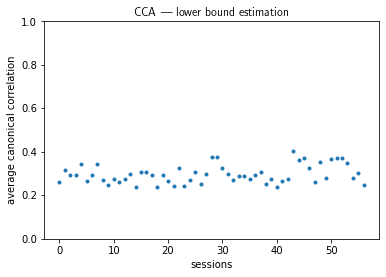

In [5]:
if "__file__" not in dir():
    plt.plot(CCs.T,'.')
    plt.ylim([0,1])
    plt.xlabel('sessions')
    plt.ylabel('average canonical correlation')
    plt.title('CCA --- lower bound estimation', usetex=True);

the average distribution of CCs

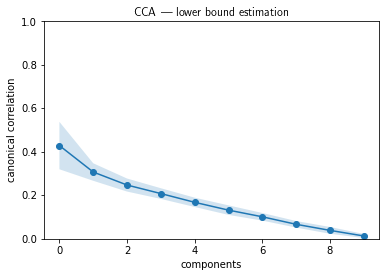

In [6]:
if "__file__" not in dir():

    CCs2=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
        CCs2.append(dt.canoncorr(data1, data2))
    CC_lower_bound = np.array(CCs2).T

    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, CC_lower_bound, marker = 'o')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- lower bound estimation', usetex=True);

## across animal, within area, across epochs, shuffled targets

so in short: different animals, different behaviours.

In [3]:
single_FileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        single_FileList1.append((I,J))

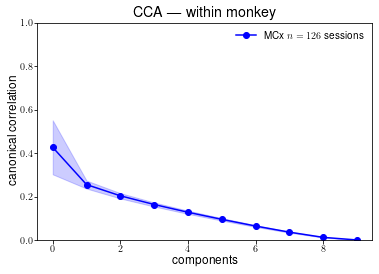

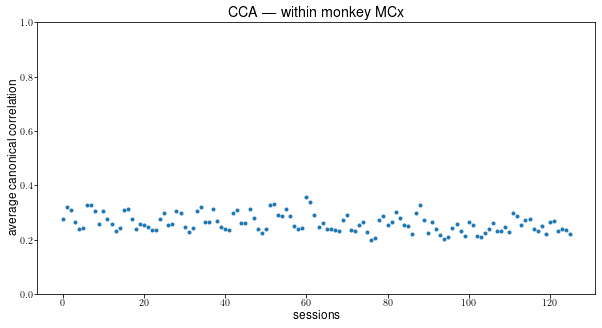

In [4]:
n_iter = 1000

#MCx
side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
side2df = [allDFs_MCx[j] for _,j in single_FileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area=defs.areas[2], model=defs.n_components)
AllData1_ = dt.get_data_array(side2df, defs.fixation_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

warnings.filterwarnings("default")

inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData1_):
    r = []
    for n in range(n_iter):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    inCCs0.append(r)
inCCs0 = np.array(inCCs0)
CC_lower_bound_MCx = np.percentile(inCCs0, 1, axis=1).T


if "__file__" in dir():  # runs when the notebook is being `imported` from another notebook
    print('variable: `CC_lower_bound_MCx` holds the lower bound correlations')
    del allDFs_MCx, side1df, side2df

# plotting
if "__file__" not in dir():
    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, CC_lower_bound_MCx, color='b', marker = 'o', label=f'{defs.areas[2]} $n={CC_lower_bound_MCx.shape[1]}$ sessions')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.legend()
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- within monkey', usetex=True);

    fig,ax = plt.subplots(ncols=1, figsize=(10,5))
    ax.plot(CC_lower_bound_MCx[:4,:].mean(axis=0),'.')
    ax.set_ylabel('average canonical correlation')
    ax.set_title(f'CCA --- within monkey {defs.areas[2]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('sessions')